# SSNE Miniproject 4
### 318703 Tomasz Owienko
### 318718 Anna Schäfer
### Grupa piątek

In [42]:
from typing import Any, Callable, Optional
from pathlib import Path
import torch
import torchvision.transforms as transforms
import torchvision
from torchmetrics.image.fid import FrechetInceptionDistance
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS, STEP_OUTPUT
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl
import matplotlib.pyplot as plt

In [43]:
RANDOM_SEED = 123
pl.seed_everything(RANDOM_SEED)

Global seed set to 123


123

In [44]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_float32_matmul_precision('medium')

In [45]:
class ImagesDataModule(pl.LightningDataModule):
    class FastDataset(Dataset):
        def __init__(self, data, labels, num_classes):
            self.dataset = data
            self.labels = labels
            self.number_classes = num_classes

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, index):
            return self.dataset[index], self.labels[index]

    def __init__(self, path: str, transform: Callable[[Any], torch.Tensor], *, val_fraction: float,
                 test_fraction: float, in_memory=False):
        super().__init__()
        assert 0 <= val_fraction + test_fraction <= 1
        assert val_fraction * test_fraction >= 0

        self.image_folder = ImageFolder(path, transform=transform)
        self.dataset: ImagesDataModule.FastDataset | None = None
        self._val_fraction = val_fraction
        self._test_fraction = test_fraction
        self._in_memory = in_memory

        self._train = self._val = self._test = None

    def prepare_data(self) -> None:
        if self._in_memory:
            loader = DataLoader(self.image_folder, batch_size=len(self.image_folder))
            data = next(iter(loader))
            dataset = ImagesDataModule.FastDataset(data[0], data[1], num_classes=len(self.image_folder.classes))
        else:
            dataset = self.image_folder

        val_size = int(len(dataset) * self._val_fraction)
        test_size = int(len(dataset) * self._test_fraction)
        train_size = len(dataset) - val_size - test_size

        self._train, self._val, self._test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self._train, batch_size=1024, shuffle=True, num_workers=12 if not self._in_memory else 0, pin_memory=True)

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self._val, batch_size=1024, shuffle=False, num_workers=12 if not self._in_memory else 0, pin_memory=True)

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self._test, batch_size=64, shuffle=False, num_workers=8 if not self._in_memory else 0, pin_memory=True)

In [46]:
# region unet

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.n_channels = n_channels

        self.inc = (DoubleConv(n_channels, 128))
        self.down1 = (Down(128, 256))
        self.down2 = (Down(256, 512))
        self.down3 = (Down(512, 1024))
        self.down4 = (Down(1024, 2048))
        self.up1 = (Up(2048, 1024))
        self.up2 = (Up(1024, 512))
        self.up3 = (Up(512, 256))
        self.up4 = (Up(256, 128))
        self.outc = (OutConv(128, n_channels))

    def forward(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

# endregion

In [47]:
# region pl-module

class DiffusionModel(pl.LightningModule):
    def __init__(self, unet: nn.Module, device=device):
        super().__init__()
        self._device = device
        self.unet = unet
        self._frechet = FrechetInceptionDistance().to(device)
    
    @staticmethod
    def corrupt(x, amount):
        """Corrupt the input `x` by mixing it with noise according to `amount`"""
        noise = torch.rand_like(x) * 2 - 1 
        amount = amount.view(-1, 1, 1, 1) 
        return x * (1 - amount) + noise * amount
    
    def forward(self, x) -> Any:
        return self.unet.forward(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = self.corrupt(x, noise_amount)
        x_hat = self(noisy_x)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer
    
    def validation_step(self, batch, batch_idx) -> Optional[STEP_OUTPUT]:
        with torch.no_grad():
            preds = self.generate(64, 1000).to(torch.float) / 255
            grid = torchvision.utils.make_grid(preds, nrow=4)
            torchvision.utils.save_image(grid, f"./generated/sample_{self.current_epoch}.png")
            gridn = torchvision.utils.make_grid(preds)
            torchvision.utils.save_image(gridn, f"./generated/sample_{self.current_epoch}_n.png")
        # n_steps = 40
        # images, _ = batch
        # distance = self.calc_frechet(images=images, n_steps=n_steps)
        # self.log(f"val_frechet_{n_steps}", distance)
        # return distance
    
    def calc_frechet(self, images, n_steps):
        """Expecting input to be normalized [-1, 1]"""
        generated = self.generate(n_images=len(images), n_steps=n_steps).to(self._device)
        self._frechet.update(self._denormalize(images), real=True)
        self._frechet.update(self._denormalize(generated), real=False)
        return self._frechet.compute()
    
    def generate(self, n_images, n_steps):
        """Denormalized, (N, 3, H, W) of torch.uint8"""
        return self._denormalize(self._generate(n_images=n_images, n_steps=n_steps))
    
    @staticmethod
    def _denormalize(images):
        """Transform from [-1, 1] to [0, 255] of type torch.uint8"""
        return images.add(1).mul(127.5).clamp(0, 255).to(torch.uint8)
        
    
    def _generate(self, n_images, n_steps):        
        """Normalized, (N, 3, H, W) of torch.float32"""
        with torch.no_grad():
            x = 2 * (torch.rand(n_images, 3, 32, 32) - 1).to(self._device)
            for i in range(n_steps):
                pred = self(x)
                mix_factor = 1 / (n_steps - i)
                x = x * (1 - mix_factor) + pred * mix_factor
            return x

# endregion

In [48]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5)),
])

dm = ImagesDataModule('data/trafic_32', transform, val_fraction=0.005, test_fraction=0.)

In [49]:
# CHECKPOINT: str | None = 'lightning_logs/version_0/checkpoints/checkpoint-epoch=47-val_frechet=253.98.ckpt'
CHECKPOINT: str | None = None

if CHECKPOINT:
    model = DiffusionModel.load_from_checkpoint(
        CHECKPOINT,
        unet = UNet(3)
    ).to(device)
else:
    model = DiffusionModel(UNet(3)).to(device)

best_frechet_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="val_frechet",
    mode="min",
    filename="checkpoint-{epoch:02d}-{train_loss:.2f}-{val_frechet:.2f}",
)

last_epoch_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="epoch",
    mode="max",
    filename="checkpoint_last-{epoch:02d}-{train_loss:.2f}-{val_frechet:.2f}",
)

periodic_callback = ModelCheckpoint(
    save_top_k=-1,
    every_n_epochs=20,
    filename="checkpoint_periodic-{epoch:02d}-{train_loss:.2f}-{val_frechet:.2f}",
)

trainer = pl.Trainer(
    max_epochs=400, 
    callbacks=[
        # best_frechet_callback,
        periodic_callback,
        last_epoch_callback
    ], 
    check_val_every_n_epoch=1
)

trainer.fit(model, datamodule=dm, ckpt_path=CHECKPOINT)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                     | Params
------------------------------------------------------
0 | unet     | UNet                     | 31.0 M
1 | _frechet | FrechetInceptionDistance | 23.9 M
------------------------------------------------------
31.0 M    Trainable params
23.9 M    Non-trainable params
54.9 M    Total params
219.555   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [52]:
# NOTE: for some reason (spent 3h figuring out why), if training was resumed from a checkpoint, 
# the model has to be re-loaded before evaluation - in other case, results are essentially garbage

model.eval()

LOGS_PATH = Path("lightning_logs")
CHECKPOINTS_PATH = max(LOGS_PATH.glob("./*"), key=lambda x: int(x.name.split("_")[-1])) / "checkpoints"
print(f"Using checkpoints from {CHECKPOINTS_PATH} ({len([f for f in CHECKPOINTS_PATH.glob('./*')])} checkpoints)")

# best_frechet_checkpoint = min((f for f in CHECKPOINTS_PATH.glob('./*') if not f.stem.startswith("checkpoint_last")),  key=lambda x: float(x.stem.split('=')[-1]))
last_epoch_checkpoint = max((f for f in CHECKPOINTS_PATH.glob('./*') if f.stem.startswith("checkpoint_last")), key=lambda x: int(x.stem.split('-')[1].split('=')[-1]))
# print(f"Best Frechet: {best_frechet_checkpoint}")
print(f"Last epoch: {last_epoch_checkpoint}")

Using checkpoints from lightning_logs/version_9/checkpoints (1 checkpoints)
Last epoch: lightning_logs/version_9/checkpoints/checkpoint_last-epoch=03-train_loss=0.06-val_frechet=0.00.ckpt


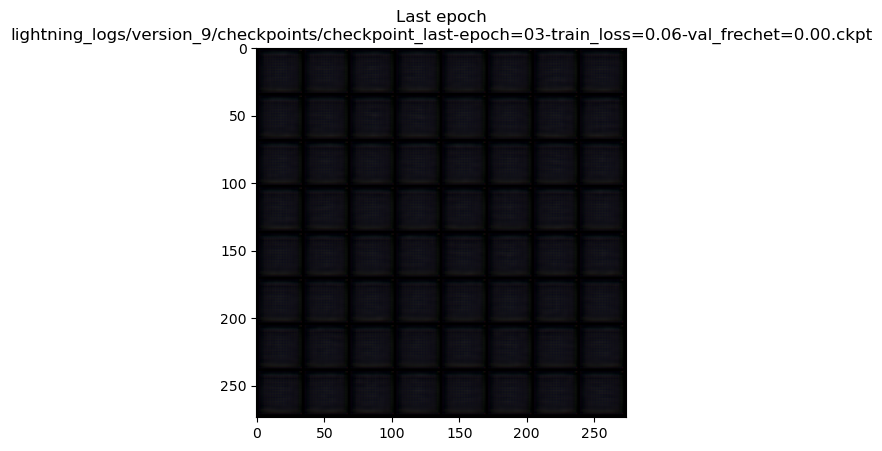

In [54]:
model.eval()

fig, axes = plt.subplots(1, 1)

for path, name, ax in zip(
        (
                # best_frechet_checkpoint, 
                last_epoch_checkpoint,
        ),
        (
                # "Best Frechet", 
                "Last epoch",
        ),
    [axes]
):
    m = DiffusionModel.load_from_checkpoint(path, unet=UNet(3)).to(device)
    m.eval()

    with torch.no_grad():
        preds = m.generate(64, 1000).cpu()
    ax.set_title(f"{name}\n{path}")
    ax.imshow((torchvision.utils.make_grid(preds).permute(1, 2, 0)))

In [ ]:
# test arbitrary checkpoints here

ckpt: str | None = None

if ckpt:
    m1 = DiffusionModel.load_from_checkpoint(ckpt, unet = UNet(3))
    preds = m1.generate(64, 2000).cpu()
    print(preds.min())
    print(preds.max())
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow((torchvision.utils.make_grid(preds).permute(1, 2, 0)))